In [5]:
from IPython.core.display import HTML


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

From Probabilistic Reasoning to Decision Making
======
*(from Bayesian Hackers Book chp 2)*
`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`

___

This chapter introduces more PyMC3 syntax and variables and ways to think about how to model a system from a Bayesian perspective. It also contains tips and data visualization techniques for assessing goodness-of-fit for your Bayesian model.

##### Example: Bayesian A/B testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results. 

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards. 

Often, the post-experiment analysis is done using something called a hypothesis test like *difference of means test* or *difference of proportions test*. This involves often quantities like a "Z-score" and  "p-values". An alternative approach is the Bayesian approach to this problem which some think is much more natural. 

### A Simple Case

We will use a web-dev example analysing two sites A and B. Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us. 

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the *observed frequency* and the *true frequency* of an event. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$. Knowing the true frequency of events like:

- fraction of users who make purchases, 
- frequency of social attributes, 
- percent of internet users with cats etc. 

are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must *infer* it from observed data.

The *observed frequency* is then the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency, 0.2, differs from the true frequency, $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.


With respect to our A/B example, we are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be. 

To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. *A priori*, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [9]:
import pymc3 as pm
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data.

In [10]:
#set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
61


The observed frequency is:

In [11]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0407
Does this equal the true frequency? False


We combine the observations into the PyMC3 `observed` variable, and run our inference algorithm:

In [12]:
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:08<00:00, 8914.79draws/s]
The number of effective samples is smaller than 25% for some parameters.


We plot the posterior distribution of the unknown $p_A$ below:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


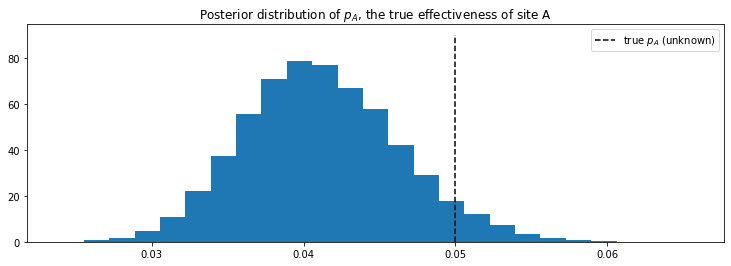

In [13]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

Our posterior distribution puts most weight near the true value of $p_A$, but also some weights in the tails. This is a measure of how uncertain we should be, given our observations. Try changing the number of observations, `N`, and observe how the posterior distribution changes.

### A and B Together

A similar analysis can be done for site B's response data to determine the analogous $p_B$. But what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, *and* $\text{delta} = p_A - p_B$, all at once. We can do this using PyMC3's deterministic variables. (We'll assume for this exercise that $p_B = 0.04$, so $\text{delta} = 0.01$, $N_B = 750$ (significantly less than $N_A$) and we will simulate site B's data like we did for site A's data )

In [98]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] ...


In [99]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.051333333333333335
0.034666666666666665


In [100]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:12<00:00, 6683.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


Below we plot the posterior distributions for the three unknowns: 

In [101]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


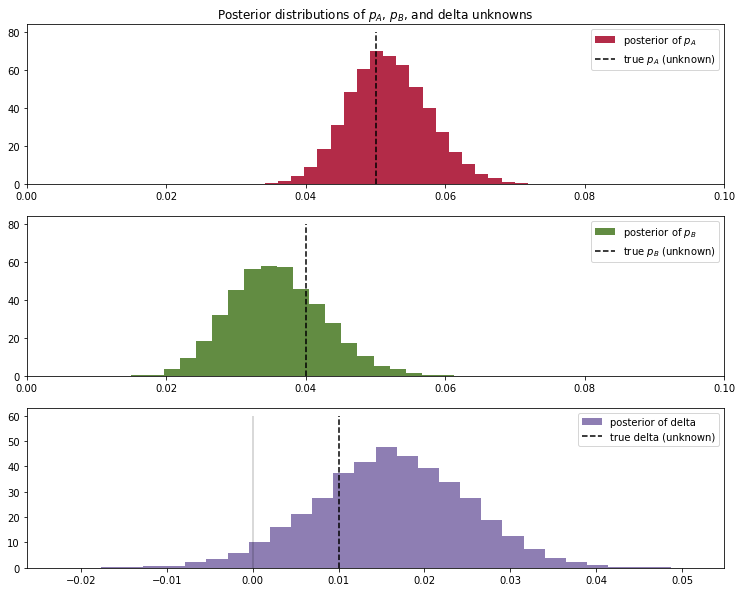

In [102]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

Notice that as a result of `N_B < N_A`, i.e. we have less data from site B, our posterior distribution of $p_B$ is fatter, implying we are less certain about the true value of $p_B$ than we are of $p_A$.  

## Analysis

With respect to the posterior distribution of $\text{delta}$, we can see that the majority of the distribution is above $\text{delta}=0$, implying there site A's response is likely better than site B's response. The probability this inference is incorrect is easily computable:

In [103]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.037
Probability site A is BETTER than site B: 0.963


If this probability is too high for comfortable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A). 

Try playing with the parameters `true_p_A`, `true_p_B`, `N_A`, and `N_B`, to see what the posterior of $\text{delta}$ looks like. Notice in all this, the difference in sample sizes between site A and site B was never mentioned: it naturally fits into Bayesian analysis.

I hope the readers feel this style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practitioners. Later in this book, we will see two extensions of this model: the first to help dynamically adjust for bad sites, and the second will improve the speed of this computation by reducing the analysis to a single equation.   

# Getting our priorities straight
*(from Bayesian Hackers Book chp 6)*

Up until now, we have mostly ignored our choice of priors. This is unfortunate as we can be very expressive with our priors, but we also must be careful about choosing them. This is especially true if we want to be objective, that is, not to express any personal beliefs in the priors. 

### Subjective vs Objective priors

Bayesian priors can be classified into two classes: *objective* priors, which aim to allow the data to influence the posterior the most, and *subjective* priors, which allow the practitioner to express his or her views into the prior. 

What is an example of an objective prior? We have seen some already, including the *flat* prior, which is a uniform distribution over the entire possible range of the unknown. Using a flat prior implies that we give each possible value an equal weighting. Choosing this type of prior is invoking what is called "The Principle of Indifference", literally we have no prior reason to favor one value over another. Calling a flat prior over a restricted space an objective prior is not correct, though it seems similar. If we know $p$ in a Binomial model is greater than 0.5, then $\text{Uniform}(0.5,1)$ is not an objective prior (since we have used prior knowledge) even though it is "flat" over [0.5, 1]. The flat prior must be flat along the *entire* range of possibilities. 

Aside from the flat prior, other examples of objective priors are less obvious, but they contain important characteristics that reflect objectivity. For now, it should be said that *rarely* is a objective prior *truly* objective. We will see this later. 

#### Subjective Priors

On the other hand, if we added more probability mass to certain areas of the prior, and less elsewhere, we are biasing our inference towards the unknowns existing in the former area. This is known as a subjective, or *informative* prior. In the figure below, the subjective prior reflects a belief that the unknown likely lives around 0.5, and not around the extremes. The objective prior is insensitive to this.

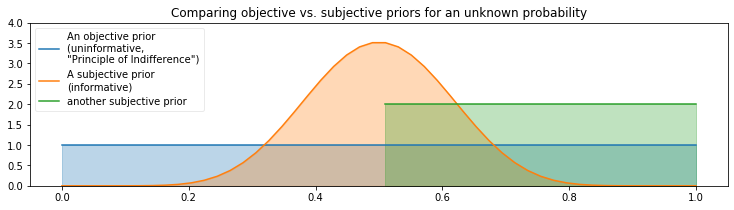

In [104]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1, y2 = stats.beta.pdf(x, 1,1), stats.beta.pdf(x, 10,10)

p = plt.plot(x, y1, 
    label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x,y2 ,
     label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color = p[0].get_color(), alpha = 0.3)

p = plt.plot(x[25:], 2*np.ones(25), label = "another subjective prior")
plt.fill_between(x[25:], 0, 2, color = p[0].get_color(), alpha = 0.3)

plt.ylim(0,4)

plt.ylim(0, 4)
leg = plt.legend(loc = "upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");

The choice of a subjective prior does not always imply that we are using the practitioner's subjective opinion: more often the subjective prior was once a posterior to a previous problem, and now the practitioner is updating this posterior with new data. A subjective prior can also be used to inject *domain knowledge* of the problem into the model. We will see examples of these two situations later.

### Decision, decisions...

The choice, either *objective* or *subjective* mostly depends on the problem being solved, but there are a few cases where one is preferred over the other. In instances of scientific research, the choice of an objective prior is obvious. This eliminates any biases in the results, and two researchers who might have differing prior opinions would feel an objective prior is fair. Consider a more extreme situation:

> A tobacco company publishes a report with a Bayesian methodology that retreated 60 years of medical research on tobacco use. Would you believe the results? Unlikely. The researchers probably chose a subjective prior that too strongly biased results in their favor.

Unfortunately, choosing an objective prior is not as simple as selecting a flat prior, and even today the problem is still not completely solved. The problem with naively choosing the uniform prior is that pathological issues can arise. Some of these issues are pedantic, but we delay more serious issues to the Appendix of this Chapter (TODO).

We must remember that choosing a prior, whether subjective or objective, is still part of the modeling process. To quote Gelman [5]:

>... after the model has been fit, one should look at the posterior distribution
and see if it makes sense. If the posterior distribution does not make sense, this implies
that additional prior knowledge is available that has not been included in the model,
and that contradicts the assumptions of the prior distribution that has been used. It is
then appropriate to go back and alter the prior distribution to be more consistent with
this external knowledge.

If the posterior does not make sense, then clearly one had an idea what the posterior *should* look like (not what one *hopes* it looks like), implying that the current prior does not contain all the prior information and should be updated. At this point, we can discard the current prior and choose a more reflective one.

Gelman [4] suggests that using a uniform distribution with large bounds is often a good choice for objective priors. Although, one should be wary about using Uniform objective priors with large bounds, as they can assign too large of a prior probability to non-intuitive points. Ask yourself: do you really think the unknown could be incredibly large? Often quantities are naturally biased towards 0. A Normal random variable with large variance (small precision) might be a better choice, or an Exponential with a fat tail in the strictly positive (or negative) case. 

If using a particularly subjective prior, it is your responsibility to be able to explain the choice of that prior, else you are no better than the tobacco company's guilty parties. 

### The Beta distribution

You may have seen the term `beta` in previous code in this book. Often, I was implementing a Beta distribution. The Beta distribution is very useful in Bayesian statistics. A random variable $X$ has a $\text{Beta}$ distribution, with parameters $(\alpha, \beta)$, if its density function is:

$$f_X(x | \; \alpha, \beta ) = \frac{ x^{(\alpha - 1)}(1-x)^{ (\beta - 1) } }{B(\alpha, \beta) }$$

where $B$ is the [Beta function](http://en.wikipedia.org/wiki/Beta_function) (hence the name). The random variable $X$ is only allowed in [0,1], making the Beta distribution a popular distribution for decimal values, probabilities and proportions. The values of $\alpha$ and $\beta$, both positive values, provide great flexibility in the shape of the distribution. Below we plot some distributions:

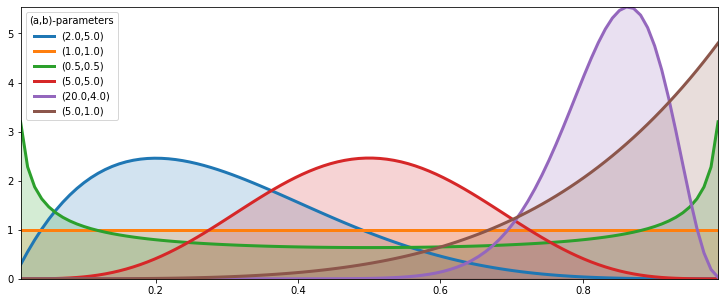

In [105]:
figsize(12.5, 5)

params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]

x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label = "(%.1f,%.1f)"%(a,b), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(loc = 'upper left', title="(a,b)-parameters");

One thing I'd like the reader to notice is the presence of the flat distribution above, specified by parameters $(1,1)$. This is the Uniform distribution. Hence the Beta distribution is a generalization of the Uniform distribution, something we will revisit many times.

There is an interesting connection between the Beta distribution and the Binomial distribution. Suppose we are interested in some unknown proportion or probability $p$. We assign a $\text{Beta}(\alpha, \beta)$ prior to $p$. We observe some data generated by a Binomial process, say $X \sim \text{Binomial}(N, p)$, with $p$ still unknown. Then our posterior *is again a Beta distribution*, i.e. $p | X \sim \text{Beta}( \alpha + X, \beta + N -X )$. Succinctly, one can relate the two by "a Beta prior with Binomial observations creates a Beta posterior". This is a very useful property, both computationally and heuristically.

**In summary:**
- if we start with a $\text{Beta}(1,1)$ prior on $p$ (which is a Uniform)
- and observe data $X \sim \text{Binomial}(N, p)$
- then our posterior is $\text{Beta}(1 + X, 1 + N - X)$. 


### Example: Bayesian Multi-Armed Bandits
*Adapted from an example by Ted Dunning of MapR Technologies*

> Suppose you are faced with $N$ slot machines (colourfully called multi-armed bandits). Each bandit has an unknown probability of distributing a prize (assume for now the prizes are the same for each bandit, only the probabilities differ). Some bandits are very generous, others not so much. Of course, you don't know what these probabilities are. By only choosing one bandit per round, our task is devise a strategy to maximize our winnings.

Of course, *if* we knew the bandit with the largest probability, then always picking this bandit would yield the maximum winnings. So our task can be phrased as 

**Task: "Find the best bandit, and as quickly as possible"**

The task is complicated by the stochastic nature of the bandits: 
- A suboptimal bandit can return many winnings, purely by chance, which would make us believe that it is a very profitable bandit. 
- Similarly, the best bandit can return many duds. 

**Question 1:**
- Should we keep trying losing bandits, or give up and move on to another?

**Question 2: Exploration - Exploitation Tradeoff** 
- If we have found a bandit that returns *pretty good* results, do we keep drawing from it to maintain our *pretty good score*? 
- *or* do we try other bandits in hopes of finding an *even-better* bandit? 

### Applications


The Multi-Armed Bandit problem at first seems very artificial, something only a mathematician would love, but that is only before we address some applications:

- Internet display advertising: companies have a suite of potential ads they can display to visitors, but the company is not sure which ad strategy to follow to maximize sales. This is similar to A/B testing, but has the added advantage of naturally minimizing strategies that do not work (and generalizes to A/B/C/D... strategies)
- Ecology: animals have a finite amount of energy to expend, and following certain behaviours has uncertain rewards. How does the animal maximize its fitness?
- Finance: which stock option gives the highest return, under time-varying return profiles.
- Clinical trials: a researcher would like to find the best treatment, out of many possible treatment, while minimizing losses. 
- Psychology: how does punishment and reward affect our behaviour? How do humans learn?

Many of these questions above are fundamental to the application's field.

It turns out the *optimal solution* is incredibly difficult, and it took decades for an overall solution to develop. There are also many approximately-optimal solutions which are quite good. The one I wish to discuss is one of the few solutions that can scale incredibly well. The solution is known as *Bayesian Bandits*.


### A Proposed Solution


Any proposed strategy is called an *online algorithm* (not in the internet sense, but in the continuously-being-updated sense), and more specifically a reinforcement learning algorithm. The algorithm starts in an ignorant state, where it knows nothing, and begins to acquire data by testing the system. As it acquires data and results, it learns what the best and worst behaviours are (in this case, it learns which bandit is the best). With this in mind, perhaps we can add an additional application of the Multi-Armed Bandit problem:

- Psychology: how does punishment and reward affect our behaviour? How do humans learn?


The Bayesian solution begins by assuming priors on the probability of winning for each bandit. In our vignette we assumed complete ignorance of these probabilities. So a very natural prior is the flat prior over 0 to 1. 

#### A simple Bayesian Bandit Algorithm:
For each round:

1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
2. Select the bandit with largest sample, i.e. select $B = \text{argmax}\;\; X_b$.
3. Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
4. Return to 1.

**Posterior Updating:**
- the algorithm involves sampling from $N$ distributions
- the initial priors are $\text{Beta}(\alpha=1,\beta=1)$ (a uniform distribution)
- Note that the observed result $X$ (a win or loss, encoded 1 and 0 respectfully) is Binomial. 
- Since Beta is a conjugate prior for Binomial the posterior is a against a Beta: $\text{Beta}(\alpha=1+X,\beta=1+1−X)$

**Answer to Question 1:** 
- this algorithm suggests that we *should not discard* losers
- but we should *pick them at a decreasing rate* as we gather confidence that there exist *better* bandits

This follows because **there is always a non-zero chance** that a loser will achieve the status of $B$, but the probability of this event decreases as we play more rounds (see figure below).

Below we implement Bayesian Bandits using two classes, `Bandits` that defines the slot machines, and `BayesianStrategy` which implements the above learning strategy.

In [106]:
rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return 

Below we visualize the learning of the Bayesian Bandit solution.

In [128]:
figsize(11.0, 18)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="Arm %d True prob= %.2f" % (i,prob[i]))
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

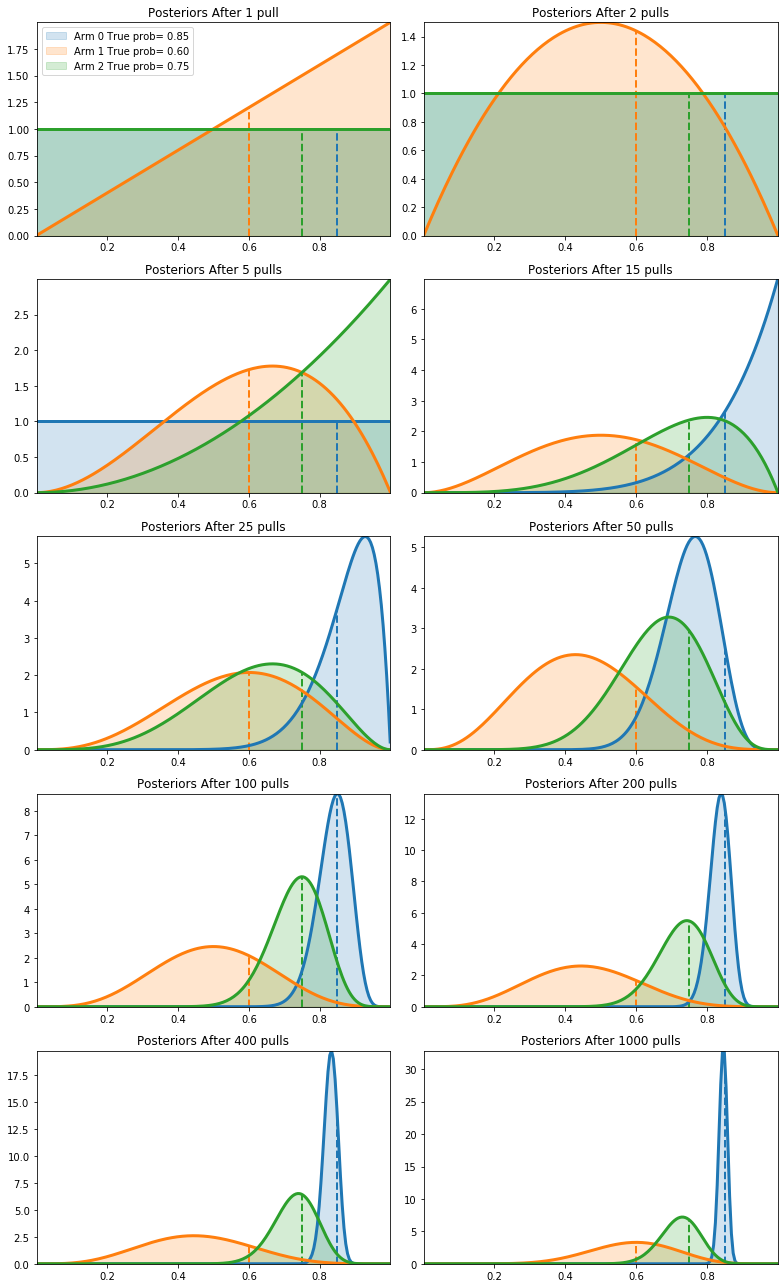

In [129]:
hidden_prob = np.array([0.85, 0.60, 0.75]) #the true probability
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

#how many additional samples to draw each iteration
draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

leg=True
for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    if leg:
        plt.legend()
        leg=False
    plt.autoscale(tight = True)
plt.tight_layout()

Note that we don't really care how accurate we become about the inference of the hidden probabilities &mdash; for this problem we are more interested in choosing the best bandit (or more accurately, becoming *more confident* in choosing the best bandit). For this reason, the distribution of the red bandit is very wide (representing ignorance about what that hidden probability might be) but we are reasonably confident that it is not the best, so the algorithm chooses to ignore it.

From the above, we can see that after 1000 pulls, the majority of the "blue" function leads the pack, hence we will almost always choose this arm. This is good, as this arm is indeed the best.


Below is a D3 app that demonstrates our algorithm updating/learning three bandits. The first figure are the raw counts of pulls and wins, and the second figure is a dynamically updating plot. I encourage you to try to guess which bandit is optimal, prior to revealing the true probabilities, by selecting the arm buttons.


In [142]:

from IPython.core.display import HTML

#try executing the below command twice if the first time doesn't work
HTML(filename = "../Chapter6_Priorities/BanditsD3.html")

Deviations of the observed ratio from the highest probability is a measure of performance. For example,in the long run, optimally we can attain the reward/pull ratio of the maximum bandit probability. Long-term realized ratios less than the maximum represent inefficiencies. (Realized ratios larger than the maximum probability is due to randomness, and will eventually fall below). 

### Regret : A Measure of *Good*

We need a metric to calculate how well we are doing. Recall the absolute *best* we can do is to **always pick the bandit with the largest probability of winning**. Denote this best bandit's probability by $w_{opt}$. Our score should be relative to how well we would have done had we chosen the best bandit from the beginning.

*Total regret* of a strategy:

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw_{opt} - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}


where $w_{B(i)}$ is the probability of a prize of the chosen bandit in the $i$ round. 

A total regret of 0 means the strategy is matching the best possible score. This is likely not possible, as initially our algorithm will often make the wrong choice.  Ideally, a strategy's total regret should flatten as it learns the best bandit. (Mathematically, we achieve $w_{B(i)}=w_{opt}$ often)


Below we plot the total regret of this simulation, including the scores of some other strategies:

1. Random: randomly choose a bandit to pull. If you can't beat this, just stop. 
2. Largest Bayesian credible bound: pick the bandit with the largest upper bound in its 95% credible region of the underlying probability. 
3. Bayes-UCB algorithm: pick the bandit with the largest *score*, where score is a dynamic quantile of the posterior (see [4] )
3. Mean of posterior: choose the bandit with the largest posterior mean. This is what a human player (sans computer) would likely do. 
3. Largest proportion: pick the bandit with the current largest observed proportion of winning. 

The code for these are in the `other_strats.py`, where you can implement your own very easily.

In [9]:
figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes , 
            max_mean,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

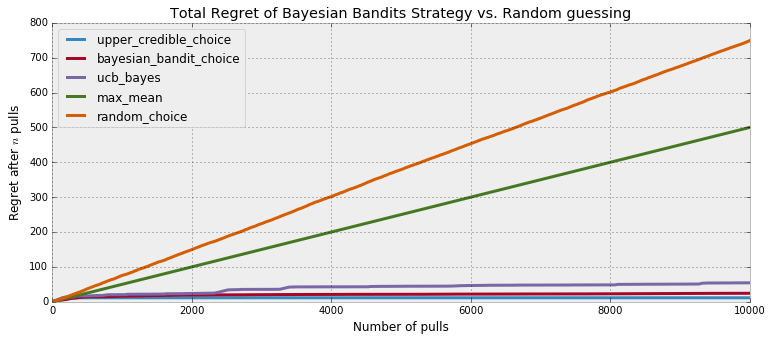

In [10]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)
    
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");

Like we wanted, Bayesian bandits and other strategies have decreasing rates of regret, representing we are achieving optimal choices. To be more scientific so as to remove any possible luck in the above simulation, we should instead look at the *expected total regret*:

$$\bar{R}_T = E[ R_T ] $$

It can be shown that any *sub-optimal* strategy's expected total regret is bounded below logarithmically. Formally,

$$ E[R_T] = \Omega \left( \;\log(T)\; \right) $$

Thus, any strategy that matches logarithmic-growing regret is said to "solve" the Multi-Armed Bandit problem [3].

Using the Law of Large Numbers, we can approximate Bayesian Bandit's expected total regret by performing the same experiment many times (500 times, to be fair):

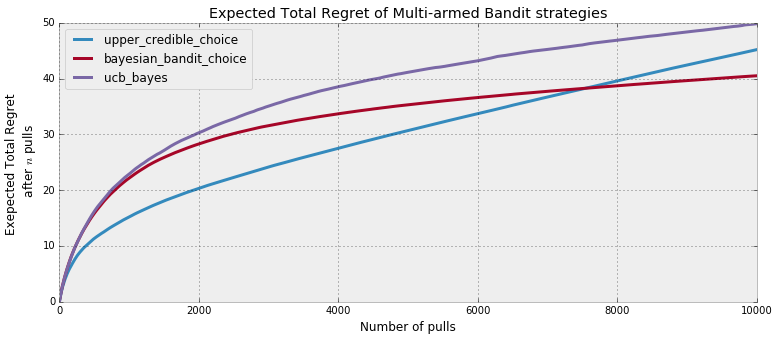

In [11]:
#this can be slow, so I recommend NOT running it. 

trials = 500
expected_total_regret = np.zeros((10000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hidden_prob, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat]/trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

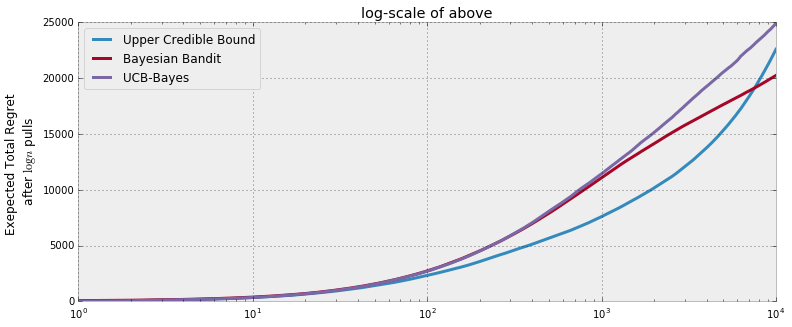

In [12]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3], 
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
            loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");